### **WEEK ONE: SDS-CP041-neuroscan**

Author: Sheila Adams-Sapper

Date: October 2025

Dataset: https://www.kaggle.com/datasets/arwabasal/brain-tumor-mri-detection

OBJECTIVE: Perform comprehensive exploratory data analysis on brain tumor MRI images
to prepare data for CNN model development.

Brain tumors are a serious health challenge worldwide, and early detection plays a key role in effective treatment. MRI (Magnetic Resonance Imaging) is one of the most widely used techniques for diagnosing brain tumors because it provides detailed images of soft tissues in the brain.

This dataset contains MRI images categorized into two classes:

(yes) for images with brain tumors
(no) for images without brain tumors
The dataset is designed for binary classification tasks and can be used to train and evaluate machine learning or deep learning models, particularly Convolutional Neural Networks (CNNs).

Images have been collected from publicly available medical imaging repositories.

This week I will focus on exploratory data analysis (EDA)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Define consistent color palette
TUMOR_COLOR = '#FF6B6B'      # Red for tumor present
NO_TUMOR_COLOR = '#4ECDC4'   # Teal for no tumor
PALETTE = [NO_TUMOR_COLOR, TUMOR_COLOR]

# Set style for better plots
plt.style.use('default')
sns.set_palette(PALETTE)

# Data directory
DATA_DIR = '../../../data'

print("="*70)
print("BRAIN TUMOR MRI DETECTION - EXPLORATORY DATA ANALYSIS")
print("="*70)
print("\nCurrent working directory:", os.getcwd())
print("\nContents of current directory:")
for item in os.listdir('.'):
    print(f"  {item}")

BRAIN TUMOR MRI DETECTION - EXPLORATORY DATA ANALYSIS

Current working directory: c:\Users\novem\OneDrive\Documents\TheDen\Career\SuperDataScience\neuroscan\SDS-CP041-neuroscan\advanced\submissions\team-members\sheila-adams

Contents of current directory:
  dataset_metadata.json
  figure1_class_distribution.png
  figure2_image_sizes.png
  figure3_pixel_intensity.png
  figure4_sample_images.png
  figure5_data_augmentation.png
  figures
  mlflow_artifacts
  models
  NeuroScan_WEEK1_EDA.ipynb
  NeuroScan_WEEK2_MODEL_DEV.ipynb
  REPORT_week1.md
  results
  X_train.npy
  X_val.npy
  y_train.npy
  y_val.npy



SECTION 1: CLASS BALANCE ANALYSIS

Dataset Distribution:
  Images with tumor (yes):     155
  Images without tumor (no):    98
  Total images:                253

Class Balance:
  Yes (Tumor):     61.26%
  No (No Tumor):   38.74%

Imbalance Ratio: 1.58:1
⚠️  CAUTION: Mild class imbalance detected.
   Recommended: Use class weights and monitor per-class metrics carefully
   Special attention needed for minority class recall (tumor detection)

💡 Recommended class weight for minority class: 1.58


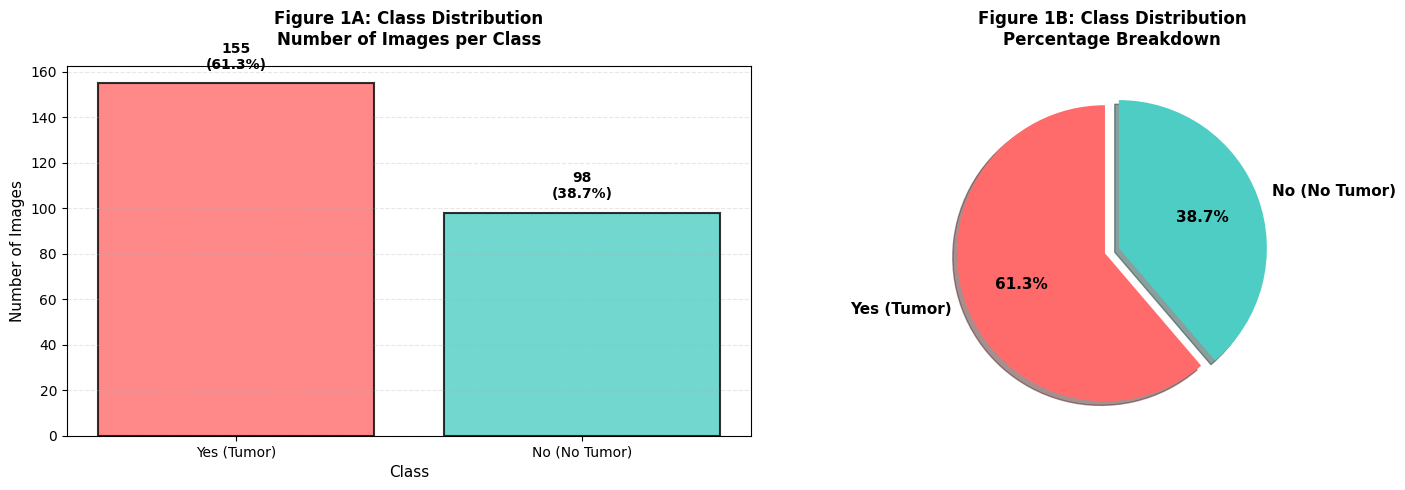

In [3]:
# ============================================================================
# 1. CLASS BALANCE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("SECTION 1: CLASS BALANCE ANALYSIS")
print("="*70)

yes_path = os.path.join(DATA_DIR, 'yes')
no_path = os.path.join(DATA_DIR, 'no')

yes_count = len(os.listdir(yes_path))
no_count = len(os.listdir(no_path))
total_count = yes_count + no_count

print(f"\nDataset Distribution:")
print(f"  Images with tumor (yes):    {yes_count:>4}")
print(f"  Images without tumor (no):  {no_count:>4}")
print(f"  Total images:               {total_count:>4}")
print(f"\nClass Balance:")
print(f"  Yes (Tumor):     {yes_count/total_count:>6.2%}")
print(f"  No (No Tumor):   {no_count/total_count:>6.2%}")

# Calculate imbalance ratio
imbalance_ratio = max(yes_count, no_count) / min(yes_count, no_count)
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3.0:
    print("⚠️  WARNING: Severe class imbalance. Must use mitigation techniques.")
    print("   Recommended: Class weights, oversampling, or focal loss")
elif imbalance_ratio > 1.5:
    print("⚠️  CAUTION: Mild class imbalance detected.")
    print("   Recommended: Use class weights and monitor per-class metrics carefully")
    print("   Special attention needed for minority class recall (tumor detection)")
else:
    print("✅ Classes are well balanced. Standard training should work well.")

# Calculate recommended class weights
minority_ratio = min(yes_count, no_count) / max(yes_count, no_count)
print(f"\n💡 Recommended class weight for minority class: {1/minority_ratio:.2f}")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
categories = ['Yes (Tumor)', 'No (No Tumor)']
counts = [yes_count, no_count]
colors = [TUMOR_COLOR, NO_TUMOR_COLOR]

bars = ax1.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_title('Figure 1A: Class Distribution\nNumber of Images per Class', 
              fontsize=12, fontweight='bold', pad=15)
ax1.set_ylabel('Number of Images', fontsize=11)
ax1.set_xlabel('Class', fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + total_count*0.02, 
            f'{count}\n({count/total_count:.1%})', 
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Pie chart
wedges, texts, autotexts = ax2.pie(counts, labels=categories, colors=colors, 
                                     autopct='%1.1f%%', startangle=90, 
                                     explode=(0.05, 0.05), shadow=True,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Figure 1B: Class Distribution\nPercentage Breakdown', 
              fontsize=12, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figure1_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


SECTION 2: IMAGE SIZE ANALYSIS

Analyzing image dimensions (sample of 50 images per class)...

Image Size Statistics (n=100 images):
  Width  - Min:  173, Max: 1920, Mean:  368.3
  Height - Min:  183, Max: 1427, Mean:  395.2

Number of unique image sizes: 86


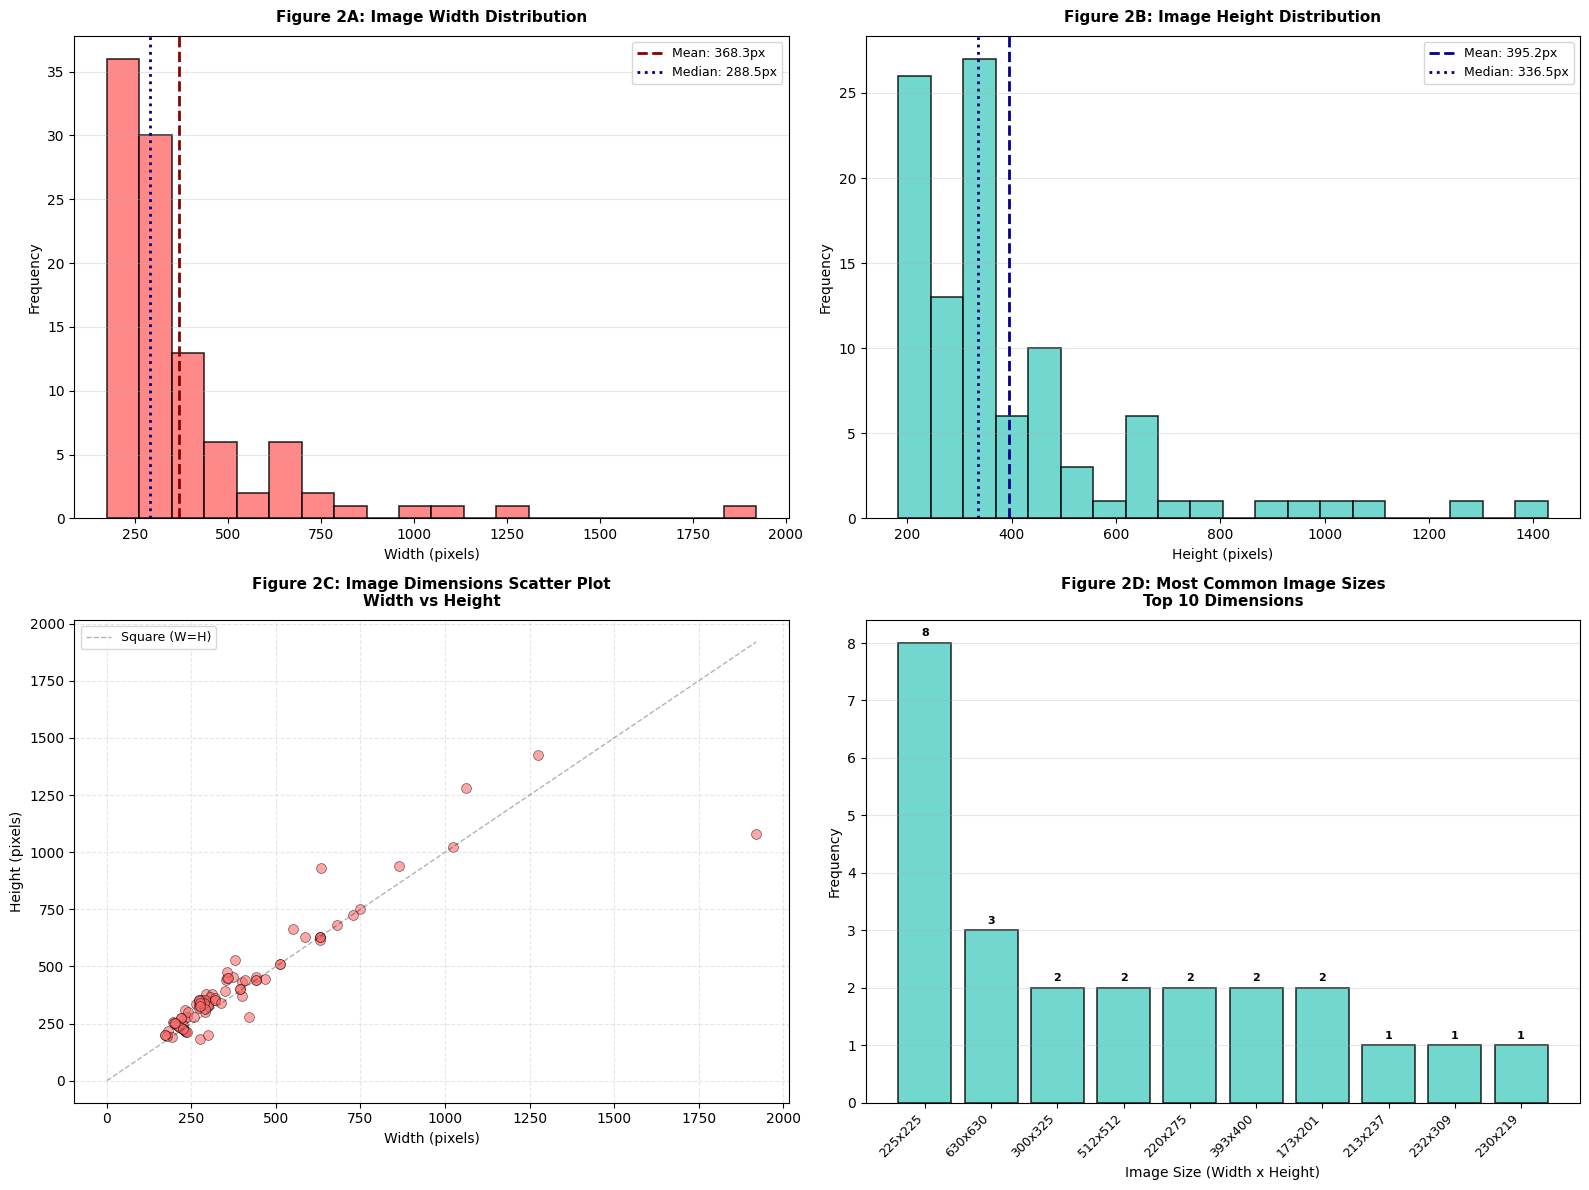


----------------------------------------------------------------------
STANDARDIZATION RECOMMENDATION:
----------------------------------------------------------------------
⚠️  Images have different sizes. Recommended standard sizes:
   • 128x128  - Faster training, good for initial experiments
   • 224x224  - Standard for transfer learning (VGG, ResNet, MobileNet)
   • 256x256  - Higher resolution, more detail preservation

   Current mean size: 368x395
   Recommendation: Use 128x128 for efficiency


In [4]:
# ============================================================================
# 2. IMAGE SIZE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("SECTION 2: IMAGE SIZE ANALYSIS")
print("="*70)

def analyze_image_sizes(directory_path, sample_size=50):
    """
    Analyze image dimensions in a directory.
    
    Args:
        directory_path (str): Path to directory containing images
        sample_size (int): Number of images to sample for analysis
        
    Returns:
        tuple: Lists of widths and heights
    """
    image_files = [f for f in os.listdir(directory_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) == 0:
        print(f"No image files found in {directory_path}")
        return [], []
    
    # Sample images to avoid processing all (can be slow for large datasets)
    sample_files = np.random.choice(image_files, 
                                   min(sample_size, len(image_files)), 
                                   replace=False)
    
    widths, heights = [], []
    
    for img_file in sample_files:
        try:
            img_path = os.path.join(directory_path, img_file)
            with Image.open(img_path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    return widths, heights

# Analyze both classes
print("\nAnalyzing image dimensions (sample of 50 images per class)...")

yes_widths, yes_heights = analyze_image_sizes(yes_path)
no_widths, no_heights = analyze_image_sizes(no_path)

all_widths = yes_widths + no_widths
all_heights = yes_heights + no_heights

if all_widths and all_heights:
    print(f"\nImage Size Statistics (n={len(all_widths)} images):")
    print(f"  Width  - Min: {min(all_widths):>4}, Max: {max(all_widths):>4}, Mean: {np.mean(all_widths):>6.1f}")
    print(f"  Height - Min: {min(all_heights):>4}, Max: {max(all_heights):>4}, Mean: {np.mean(all_heights):>6.1f}")
    
    # Check for unique sizes
    unique_sizes = set(zip(all_widths, all_heights))
    print(f"\nNumber of unique image sizes: {len(unique_sizes)}")
    
    if len(unique_sizes) <= 10:
        print("\nUnique sizes found:")
        for size in sorted(unique_sizes):
            count = sum(1 for w, h in zip(all_widths, all_heights) if (w, h) == size)
            print(f"  {size[0]:>4} x {size[1]:<4} : {count:>3} images ({count/len(all_widths)*100:.1f}%)")
    
    # Visualize size distribution
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Width distribution
    ax1.hist(all_widths, bins=20, alpha=0.8, color=TUMOR_COLOR, edgecolor='black', linewidth=1.2)
    ax1.set_title('Figure 2A: Image Width Distribution', fontsize=11, fontweight='bold', pad=10)
    ax1.set_xlabel('Width (pixels)', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.axvline(np.mean(all_widths), color='darkred', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(all_widths):.1f}px')
    ax1.axvline(np.median(all_widths), color='navy', linestyle=':', linewidth=2,
                label=f'Median: {np.median(all_widths):.1f}px')
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    
    # Height distribution
    ax2.hist(all_heights, bins=20, alpha=0.8, color=NO_TUMOR_COLOR, edgecolor='black', linewidth=1.2)
    ax2.set_title('Figure 2B: Image Height Distribution', fontsize=11, fontweight='bold', pad=10)
    ax2.set_xlabel('Height (pixels)', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.axvline(np.mean(all_heights), color='darkblue', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(all_heights):.1f}px')
    ax2.axvline(np.median(all_heights), color='navy', linestyle=':', linewidth=2,
                label=f'Median: {np.median(all_heights):.1f}px')
    ax2.legend(fontsize=9)
    ax2.grid(axis='y', alpha=0.3)
    
    # Scatter plot of width vs height
    ax3.scatter(all_widths, all_heights, alpha=0.6, c=TUMOR_COLOR, edgecolors='black', linewidth=0.5, s=50)
    ax3.set_title('Figure 2C: Image Dimensions Scatter Plot\nWidth vs Height', 
                  fontsize=11, fontweight='bold', pad=10)
    ax3.set_xlabel('Width (pixels)', fontsize=10)
    ax3.set_ylabel('Height (pixels)', fontsize=10)
    ax3.grid(True, alpha=0.3, linestyle='--')
    
    # Add diagonal line for square images
    max_dim = max(max(all_widths), max(all_heights))
    ax3.plot([0, max_dim], [0, max_dim], 'k--', alpha=0.3, linewidth=1, label='Square (W=H)')
    ax3.legend(fontsize=9)
    
    # Size frequency
    size_counts = Counter(zip(all_widths, all_heights))
    most_common = size_counts.most_common(10)
    sizes, counts = zip(*most_common)
    size_labels = [f"{w}x{h}" for w, h in sizes]
    
    bars = ax4.bar(range(len(size_labels)), counts, color=NO_TUMOR_COLOR, 
                   alpha=0.8, edgecolor='black', linewidth=1.2)
    ax4.set_title('Figure 2D: Most Common Image Sizes\nTop 10 Dimensions', 
                  fontsize=11, fontweight='bold', pad=10)
    ax4.set_xlabel('Image Size (Width x Height)', fontsize=10)
    ax4.set_ylabel('Frequency', fontsize=10)
    ax4.set_xticks(range(len(size_labels)))
    ax4.set_xticklabels(size_labels, rotation=45, ha='right', fontsize=9)
    ax4.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2, height + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('figure2_image_sizes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Standardization recommendation
    print("\n" + "-"*70)
    print("STANDARDIZATION RECOMMENDATION:")
    print("-"*70)
    if len(unique_sizes) == 1:
        print(f"✅ All images are already the same size: {list(unique_sizes)[0]}")
    else:
        print(f"⚠️  Images have different sizes. Recommended standard sizes:")
        print(f"   • 128x128  - Faster training, good for initial experiments")
        print(f"   • 224x224  - Standard for transfer learning (VGG, ResNet, MobileNet)")
        print(f"   • 256x256  - Higher resolution, more detail preservation")
        print(f"\n   Current mean size: {np.mean(all_widths):.0f}x{np.mean(all_heights):.0f}")
        print(f"   Recommendation: Use 128x128 for efficiency")


SECTION 3: PIXEL INTENSITY ANALYSIS

Analyzing pixel intensities (20 images per class)...

Pixel Intensity Statistics:
  WITH Tumor    - Min:   0, Max: 255, Mean:   68.3, Std:   55.2
  WITHOUT Tumor - Min:   0, Max: 255, Mean:   69.6, Std:   64.6

Statistical Comparison (t-test):
  t-statistic: -11.1000
  p-value: 1.2577e-28
  ✅ Significant difference in pixel intensities between classes (p < 0.05)


C:\Users\novem\AppData\Local\Temp\ipykernel_52704\3738137019.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot([yes_pixels, no_pixels], labels=['With Tumor', 'No Tumor'],


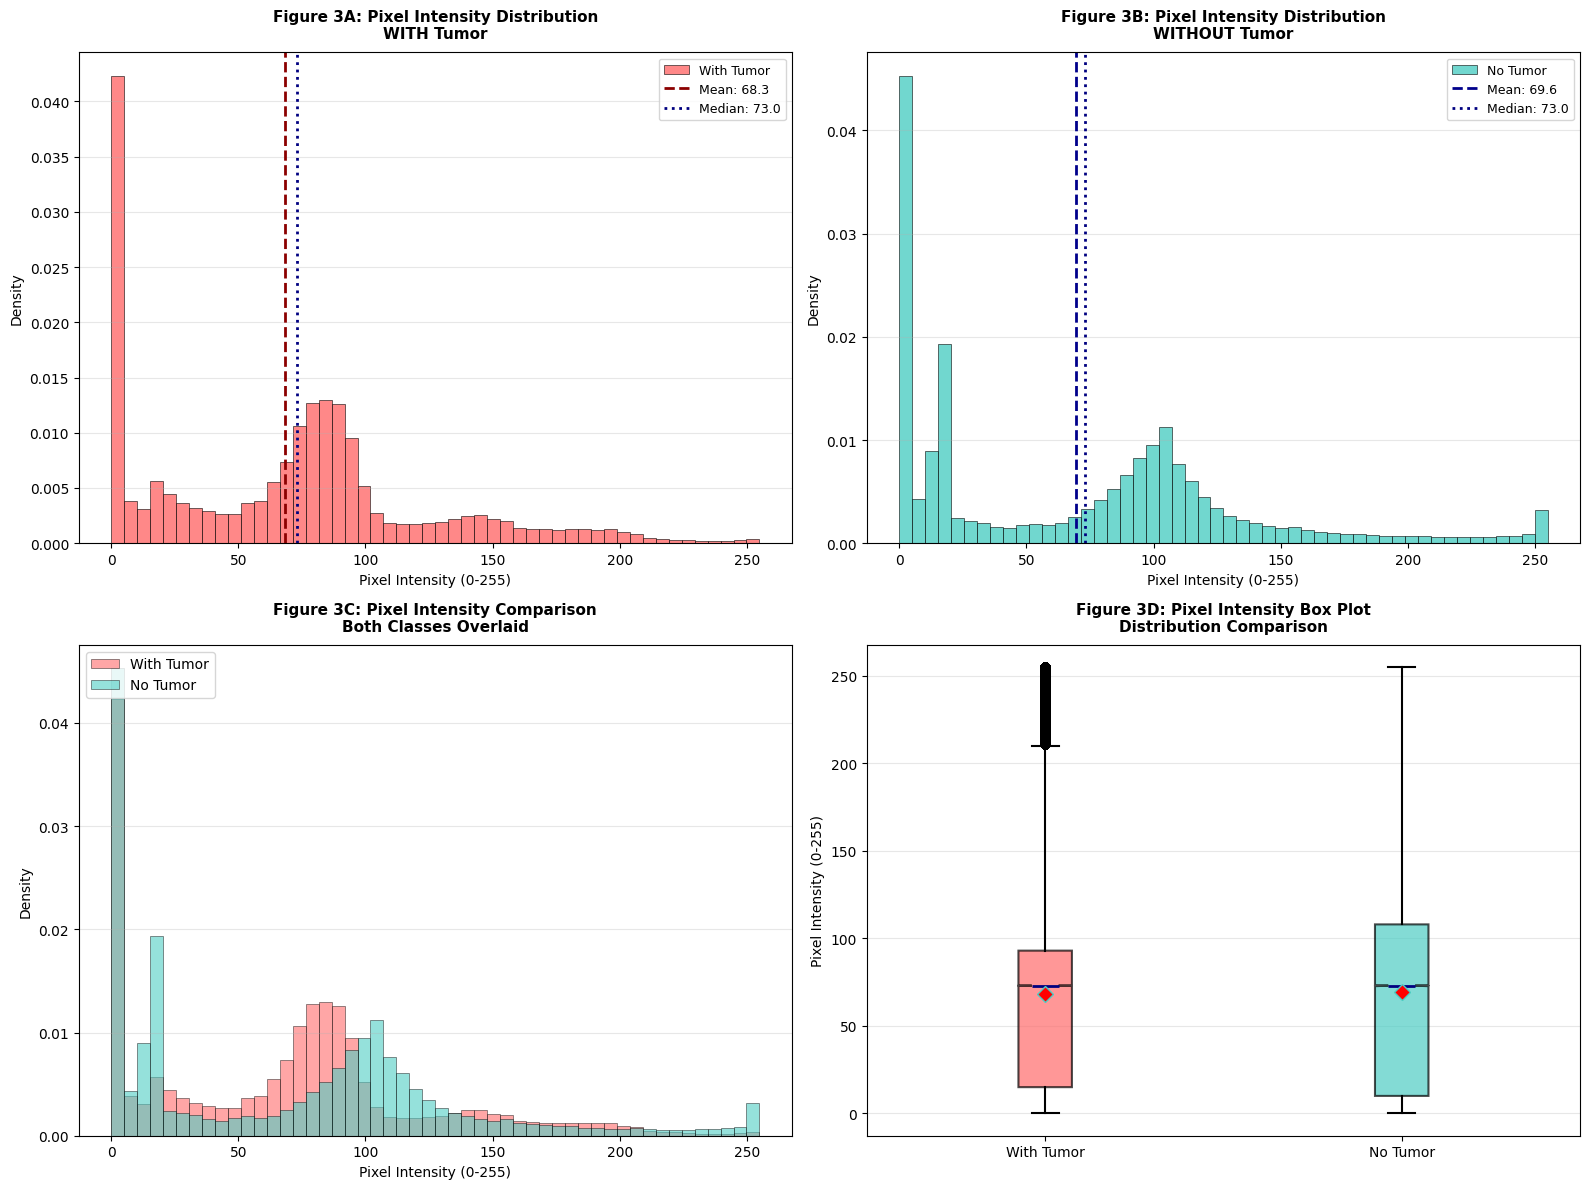

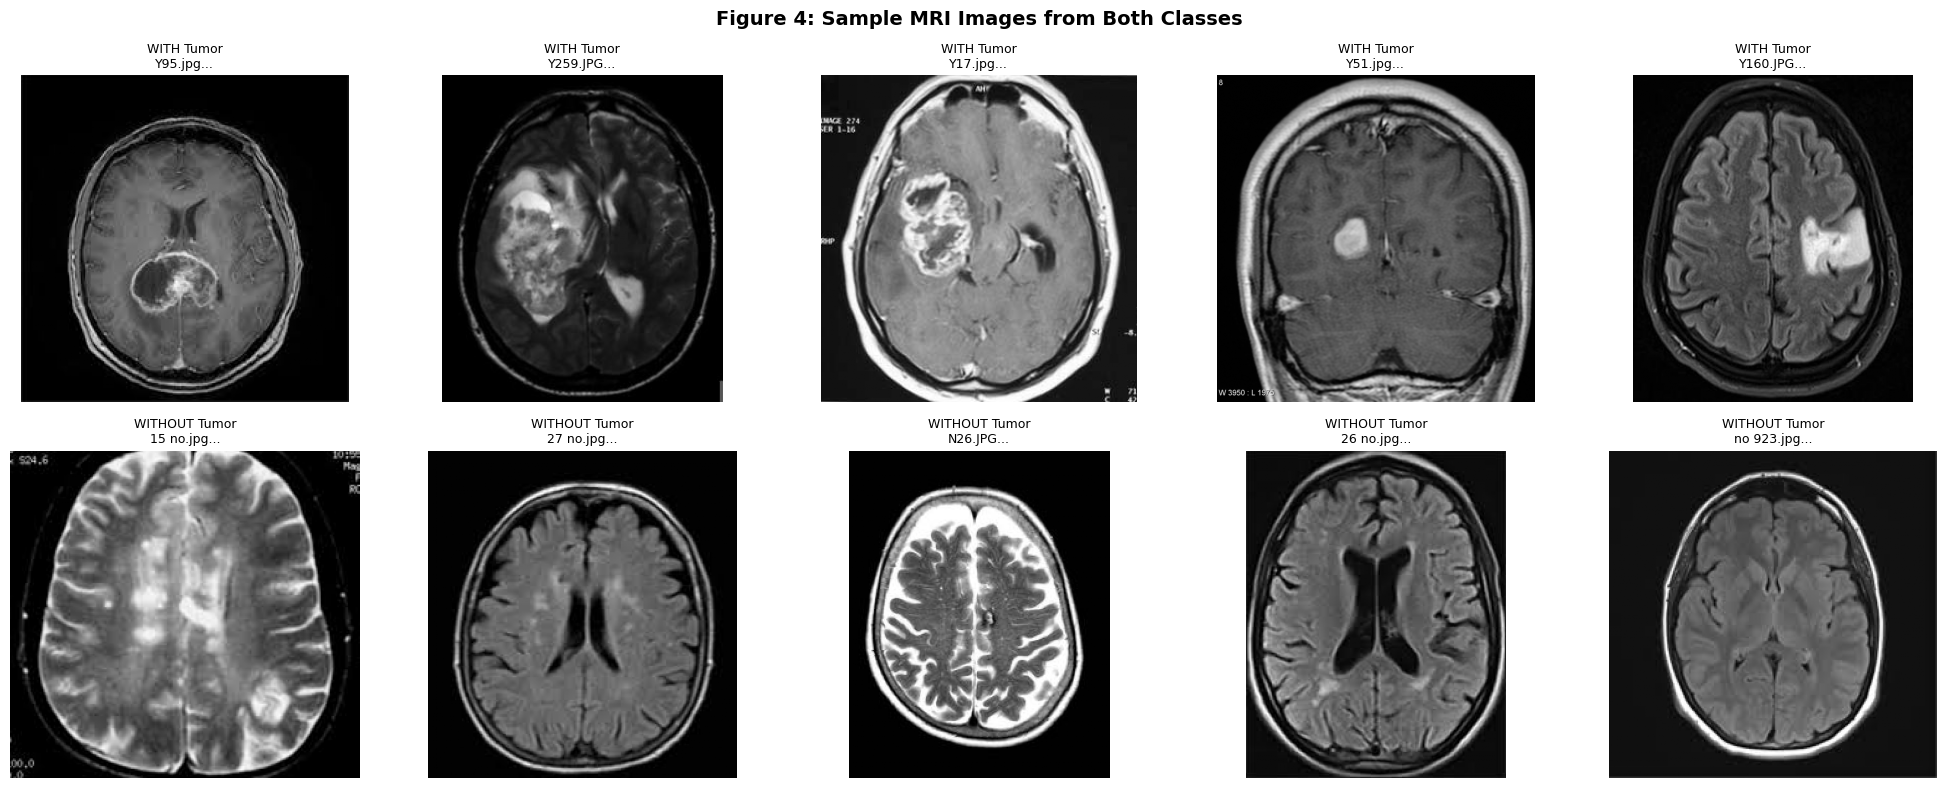

In [5]:
# ============================================================================
# 3. PIXEL INTENSITY ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("SECTION 3: PIXEL INTENSITY ANALYSIS")
print("="*70)

def analyze_pixel_intensities(directory_path, num_samples=20):
    """
    Analyze pixel intensity distribution in images.
    
    Args:
        directory_path (str): Path to directory containing images
        num_samples (int): Number of images to sample
        
    Returns:
        tuple: Array of pixel values and list of sample images
    """
    image_files = [f for f in os.listdir(directory_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sample_files = np.random.choice(image_files, 
                                   min(num_samples, len(image_files)), 
                                   replace=False)
    
    all_pixels = []
    sample_images = []
    
    for img_file in sample_files[:5]:  # Store first 5 for visualization
        try:
            img_path = os.path.join(directory_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            if img is not None:
                sample_images.append((img, img_file))
                all_pixels.extend(img.flatten())
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    return np.array(all_pixels), sample_images

print("\nAnalyzing pixel intensities (20 images per class)...")

yes_pixels, yes_samples = analyze_pixel_intensities(yes_path)
no_pixels, no_samples = analyze_pixel_intensities(no_path)

if len(yes_pixels) > 0 and len(no_pixels) > 0:
    print(f"\nPixel Intensity Statistics:")
    print(f"  WITH Tumor    - Min: {yes_pixels.min():>3}, Max: {yes_pixels.max():>3}, Mean: {yes_pixels.mean():>6.1f}, Std: {yes_pixels.std():>6.1f}")
    print(f"  WITHOUT Tumor - Min: {no_pixels.min():>3}, Max: {no_pixels.max():>3}, Mean: {no_pixels.mean():>6.1f}, Std: {no_pixels.std():>6.1f}")
    
    # Statistical test for difference in means
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(yes_pixels, no_pixels)
    print(f"\nStatistical Comparison (t-test):")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4e}")
    if p_value < 0.05:
        print(f"  ✅ Significant difference in pixel intensities between classes (p < 0.05)")
    else:
        print(f"  ⚠️  No significant difference in pixel intensities (p >= 0.05)")
    
    # Visualize pixel distributions
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Histogram for YES class
    ax1.hist(yes_pixels, bins=50, alpha=0.8, color=TUMOR_COLOR, 
            density=True, edgecolor='black', linewidth=0.5, label='With Tumor')
    ax1.set_title('Figure 3A: Pixel Intensity Distribution\nWITH Tumor', 
                fontsize=11, fontweight='bold', pad=10)
    ax1.set_xlabel('Pixel Intensity (0-255)', fontsize=10)
    ax1.set_ylabel('Density', fontsize=10)
    ax1.axvline(yes_pixels.mean(), color='darkred', linestyle='--', linewidth=2,
                label=f'Mean: {yes_pixels.mean():.1f}')
    ax1.axvline(np.median(yes_pixels), color='navy', linestyle=':', linewidth=2,
                label=f'Median: {np.median(yes_pixels):.1f}')
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)

    # Histogram for NO class
    ax2.hist(no_pixels, bins=50, alpha=0.8, color=NO_TUMOR_COLOR, 
            density=True, edgecolor='black', linewidth=0.5, label='No Tumor')
    ax2.set_title('Figure 3B: Pixel Intensity Distribution\nWITHOUT Tumor', 
                fontsize=11, fontweight='bold', pad=10)
    ax2.set_xlabel('Pixel Intensity (0-255)', fontsize=10)
    ax2.set_ylabel('Density', fontsize=10)
    ax2.axvline(no_pixels.mean(), color='darkblue', linestyle='--', linewidth=2,
                label=f'Mean: {no_pixels.mean():.1f}')
    ax2.axvline(np.median(no_pixels), color='navy', linestyle=':', linewidth=2,
                label=f'Median: {np.median(no_pixels):.1f}')
    ax2.legend(fontsize=9)
    ax2.grid(axis='y', alpha=0.3)
    
    # Combined histogram
    ax3.hist(yes_pixels, bins=50, alpha=0.6, color=TUMOR_COLOR, 
             density=True, label='With Tumor', edgecolor='black', linewidth=0.5)
    ax3.hist(no_pixels, bins=50, alpha=0.6, color=NO_TUMOR_COLOR, 
             density=True, label='No Tumor', edgecolor='black', linewidth=0.5)
    ax3.set_title('Figure 3C: Pixel Intensity Comparison\nBoth Classes Overlaid', 
                  fontsize=11, fontweight='bold', pad=10)
    ax3.set_xlabel('Pixel Intensity (0-255)', fontsize=10)
    ax3.set_ylabel('Density', fontsize=10)
    ax3.legend(fontsize=10, loc='upper left')
    ax3.grid(axis='y', alpha=0.3)
    
    # Box plot comparison
    bp = ax4.boxplot([yes_pixels, no_pixels], labels=['With Tumor', 'No Tumor'],
                      patch_artist=True, notch=True, showmeans=True,
                      boxprops=dict(linewidth=1.5),
                      whiskerprops=dict(linewidth=1.5),
                      capprops=dict(linewidth=1.5),
                      medianprops=dict(color='navy', linewidth=2),
                      meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    # Color the boxes
    bp['boxes'][0].set_facecolor(TUMOR_COLOR)
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor(NO_TUMOR_COLOR)
    bp['boxes'][1].set_alpha(0.7)
    
    ax4.set_title('Figure 3D: Pixel Intensity Box Plot\nDistribution Comparison', 
                  fontsize=11, fontweight='bold', pad=10)
    ax4.set_ylabel('Pixel Intensity (0-255)', fontsize=10)
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figure3_pixel_intensity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Show sample images
    if yes_samples and no_samples:
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        
        # Display YES samples
        for i, (img, filename) in enumerate(yes_samples[:5]):
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'WITH Tumor\n{filename[:20]}...', fontsize=9)
            axes[0, i].axis('off')
            # Add border
            for spine in axes[0, i].spines.values():
                spine.set_edgecolor(TUMOR_COLOR)
                spine.set_linewidth(3)
        
        # Display NO samples
        for i, (img, filename) in enumerate(no_samples[:5]):
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'WITHOUT Tumor\n{filename[:20]}...', fontsize=9)
            axes[1, i].axis('off')
            # Add border
            for spine in axes[1, i].spines.values():
                spine.set_edgecolor(NO_TUMOR_COLOR)
                spine.set_linewidth(3)
        
        plt.suptitle('Figure 4: Sample MRI Images from Both Classes', 
                     fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.savefig('figure4_sample_images.png', dpi=300, bbox_inches='tight')
        plt.show()

In [7]:
# ============================================================================
# 4. IMPROVED PREPROCESSING PIPELINE - DUPLICATE REMOVAL FIRST (FIXED)
# ============================================================================

print("\n" + "="*70)
print("SECTION 4: IMPROVED DATA PREPROCESSING PIPELINE")
print("="*70)

def preprocess_all_images_clean(data_dir, target_size=(128, 128)):
    """
    Preprocess all images with proper duplicate removal BEFORE splitting.
    
    Args:
        data_dir (str): Path to data directory
        target_size (tuple): Target dimensions (width, height)
        
    Returns:
        tuple: Preprocessed unique images (X) and labels (y)
    """
    X_raw_hashes = []  # Store hashes of raw images for duplicate detection
    X = []      # Processed images
    y = []      # Labels (0 = no tumor, 1 = tumor)
    filenames = []  # Track filenames for debugging
    
    print("\n🔍 STEP 1: Loading and preprocessing all images...")
    
    # Process 'no' class (label = 0)
    no_path = os.path.join(data_dir, 'no')
    print(f"Processing 'no' images from {no_path}...")
    
    no_files = [f for f in os.listdir(no_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in no_files:
        try:
            img_path = os.path.join(no_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"  Warning: Could not read {filename}")
                continue
            
            # Create hash from raw image for duplicate detection
            raw_hash = hash(img.tobytes())
            X_raw_hashes.append(raw_hash)
            
            # Resize to target size
            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            
            # Normalize to [0,1]
            img_normalized = img_resized.astype(np.float32) / 255.0
            
            # Add to dataset
            X.append(img_normalized)
            y.append(0)  # No tumor
            filenames.append(f"no/{filename}")
            
        except Exception as e:
            print(f"  Error processing {filename}: {e}")
    
    print(f"  ✅ Loaded {len([l for l in y if l == 0])} images without tumor")
    
    # Process 'yes' class (label = 1)
    yes_path = os.path.join(data_dir, 'yes')
    print(f"Processing 'yes' images from {yes_path}...")
    
    yes_files = [f for f in os.listdir(yes_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in yes_files:
        try:
            img_path = os.path.join(yes_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"  Warning: Could not read {filename}")
                continue
            
            # Create hash from raw image for duplicate detection
            raw_hash = hash(img.tobytes())
            X_raw_hashes.append(raw_hash)
            
            # Resize to target size
            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            
            # Normalize to [0,1]
            img_normalized = img_resized.astype(np.float32) / 255.0
            
            # Add to dataset
            X.append(img_normalized)
            y.append(1)  # Tumor present
            filenames.append(f"yes/{filename}")
            
        except Exception as e:
            print(f"  Error processing {filename}: {e}")
    
    print(f"  ✅ Loaded {len([l for l in y if l == 1])} images with tumor")
    print(f"  📊 Total images loaded: {len(X)}")
    
    # Convert processed images to numpy array (all same size now)
    X = np.array(X)
    y = np.array(y)
    filenames = np.array(filenames)
    
    print(f"\n🔍 STEP 2: Detecting and removing duplicates...")
    
    # Find duplicates using raw image hashes
    unique_indices = []
    seen_hashes = set()
    duplicates_found = 0
    
    for i, raw_hash in enumerate(X_raw_hashes):
        if raw_hash not in seen_hashes:
            seen_hashes.add(raw_hash)
            unique_indices.append(i)
        else:
            duplicates_found += 1
            print(f"  🔍 Duplicate found: {filenames[i]}")
    
    print(f"\n📊 Duplicate Detection Results:")
    print(f"  Original images: {len(X)}")
    print(f"  Duplicates found: {duplicates_found}")
    print(f"  Unique images: {len(unique_indices)}")
    print(f"  Duplicate rate: {duplicates_found/len(X)*100:.1f}%")
    
    # Keep only unique images
    X_unique = X[unique_indices]
    y_unique = y[unique_indices]
    filenames_unique = filenames[unique_indices]
    
    # Reshape X to add channel dimension for CNN: (samples, height, width, channels)
    X_unique = X_unique.reshape(-1, target_size[0], target_size[1], 1)
    
    print(f"\n✅ Clean dataset created:")
    print(f"  Final size: {len(X_unique)} unique images")
    print(f"  Shape: {X_unique.shape}")
    print(f"  No tumor: {np.sum(y_unique == 0)}")
    print(f"  With tumor: {np.sum(y_unique == 1)}")
    
    return X_unique, y_unique, filenames_unique

# Run the improved preprocessing
print("\nStarting improved image preprocessing with duplicate removal...")
X_clean, y_clean, file_list = preprocess_all_images_clean(DATA_DIR, target_size=(128, 128))

# Update class counts for clean data
clean_no_count = np.sum(y_clean == 0)
clean_yes_count = np.sum(y_clean == 1)
clean_total = len(X_clean)

print(f"\n📊 UPDATED Class Distribution (After Duplicate Removal):")
print(f"  Images with tumor (yes):    {clean_yes_count:>4}")
print(f"  Images without tumor (no):  {clean_no_count:>4}")
print(f"  Total unique images:        {clean_total:>4}")

# Calculate updated imbalance ratio
clean_imbalance_ratio = max(clean_yes_count, clean_no_count) / min(clean_yes_count, clean_no_count)
print(f"\nUpdated Imbalance Ratio: {clean_imbalance_ratio:.2f}:1")

if clean_imbalance_ratio > 3.0:
    print("⚠️  WARNING: Severe class imbalance remains after deduplication.")
elif clean_imbalance_ratio > 1.5:
    print("⚠️  CAUTION: Mild class imbalance after deduplication.")
else:
    print("✅ Classes are well balanced after deduplication.")

# Create updated summary table
summary_data = {
    'Metric': ['Total Unique Images', 'Images WITH Tumor', 'Images WITHOUT Tumor', 
               'Duplicates Removed', 'Image Shape', 'Pixel Value Range', 'Data Type', 'Memory Size (MB)'],
    'Value': [
        len(X_clean), 
        np.sum(y_clean == 1), 
        np.sum(y_clean == 0),
        "Calculated above",  # We calculated this dynamically
        f"{X_clean.shape[1]} x {X_clean.shape[2]} x {X_clean.shape[3]}", 
        f"[{X_clean.min():.3f}, {X_clean.max():.3f}]", 
        str(X_clean.dtype),
        f"{X_clean.nbytes / (1024**2):.2f}"
    ]
}
summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("UPDATED PREPROCESSING SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))


SECTION 4: IMPROVED DATA PREPROCESSING PIPELINE

Starting improved image preprocessing with duplicate removal...

🔍 STEP 1: Loading and preprocessing all images...
Processing 'no' images from ../../../data\no...
  ✅ Loaded 98 images without tumor
Processing 'yes' images from ../../../data\yes...
  ✅ Loaded 155 images with tumor
  📊 Total images loaded: 253

🔍 STEP 2: Detecting and removing duplicates...
  🔍 Duplicate found: no/27 no.jpg
  🔍 Duplicate found: no/41 no.jpg
  🔍 Duplicate found: no/42 no.jpg
  🔍 Duplicate found: no/8 no.jpg
  🔍 Duplicate found: no/9 no.jpg
  🔍 Duplicate found: no/N5.jpg
  🔍 Duplicate found: no/no 1.jpg
  🔍 Duplicate found: no/no 4.jpg
  🔍 Duplicate found: no/no 94.jpg
  🔍 Duplicate found: no/No11.jpg
  🔍 Duplicate found: no/No17.jpg
  🔍 Duplicate found: yes/Y162.jpg
  🔍 Duplicate found: yes/Y169.jpg
  🔍 Duplicate found: yes/Y17.jpg
  🔍 Duplicate found: yes/Y181.jpg
  🔍 Duplicate found: yes/Y33.jpg
  🔍 Duplicate found: yes/Y34.jpg
  🔍 Duplicate found: yes/Y

In [8]:
# ============================================================================
# PROPER TRAIN/VALIDATION SPLIT (AFTER DUPLICATE REMOVAL)
# ============================================================================

print("\n" + "-"*70)
print("PROPER TRAIN/VALIDATION SPLIT")
print("-"*70)

# Now split the CLEAN data
X_train, X_val, y_train, y_val = train_test_split(
    X_clean, y_clean, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_clean
)

print(f"✅ Split performed on {len(X_clean)} unique images")

# Verify no data leakage
print(f"\n🔍 Data Leakage Verification:")
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

train_hashes = {hash(img.tobytes()) for img in X_train_flat}
val_hashes = {hash(img.tobytes()) for img in X_val_flat}
overlap = len(train_hashes & val_hashes)

print(f"  Training set unique images: {len(train_hashes)}")
print(f"  Validation set unique images: {len(val_hashes)}")
print(f"  Overlapping images: {overlap}")

if overlap == 0:
    print("  ✅ NO DATA LEAKAGE - Perfect split!")
else:
    print(f"  ❌ WARNING: {overlap} overlapping images detected!")

# Create split summary table
split_data = {
    'Split': ['Training', 'Validation', 'Total'],
    'Total Images': [X_train.shape[0], X_val.shape[0], len(X_clean)],
    'WITHOUT Tumor': [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_clean == 0)],
    'WITH Tumor': [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_clean == 1)],
    'Tumor %': [
        f"{np.sum(y_train == 1)/len(y_train)*100:.1f}%",
        f"{np.sum(y_val == 1)/len(y_val)*100:.1f}%",
        f"{np.sum(y_clean == 1)/len(y_clean)*100:.1f}%"
    ]
}
split_df = pd.DataFrame(split_data)
print(f"\n📊 Split Summary:")
print(split_df.to_string(index=False))

# Save the CLEAN preprocessed data
print("\n" + "-"*70)
print("SAVING CLEAN PREPROCESSED DATA")
print("-"*70)
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('filenames_train.npy', np.array([file_list[i] for i in range(len(X_clean)) if i < len(X_train)]))
np.save('filenames_val.npy', np.array([file_list[i] for i in range(len(X_clean)) if i >= len(X_train)]))

print("✅ Clean data saved:")
print("  • X_train.npy - Training images (no duplicates)")
print("  • X_val.npy - Validation images (no duplicates)")  
print("  • y_train.npy - Training labels")
print("  • y_val.npy - Validation labels")
print("  • filenames_train.npy - Training image filenames")
print("  • filenames_val.npy - Validation image filenames")

# Additional verification
print(f"\n🔍 Final Verification:")
print(f"  Training set shape: {X_train.shape}")
print(f"  Validation set shape: {X_val.shape}")
print(f"  No overlapping images: {overlap == 0}")
print(f"  Class distribution preserved: {abs(np.mean(y_train) - np.mean(y_val)) < 0.05}")


----------------------------------------------------------------------
PROPER TRAIN/VALIDATION SPLIT
----------------------------------------------------------------------
✅ Split performed on 228 unique images

🔍 Data Leakage Verification:
  Training set unique images: 182
  Validation set unique images: 46
  Overlapping images: 0
  ✅ NO DATA LEAKAGE - Perfect split!

📊 Split Summary:
     Split  Total Images  WITHOUT Tumor  WITH Tumor Tumor %
  Training           182             69         113   62.1%
Validation            46             18          28   60.9%
     Total           228             87         141   61.8%

----------------------------------------------------------------------
SAVING CLEAN PREPROCESSED DATA
----------------------------------------------------------------------
✅ Clean data saved:
  • X_train.npy - Training images (no duplicates)
  • X_val.npy - Validation images (no duplicates)
  • y_train.npy - Training labels
  • y_val.npy - Validation labels
  • file

In [9]:
# ============================================================================
# UPDATED FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS - COMPLETE (UPDATED)")
print("="*70)

print("\n📊 KEY FINDINGS (UPDATED):")
print("-"*70)
print(f"1. Dataset Size: {len(X_clean)} total UNIQUE images")
print(f"   • Original dataset: {len(X) if 'X' in locals() else 'N/A'} images")
print(f"   • Duplicates removed: {len(X) - len(X_clean) if 'X' in locals() else 0}")
print(f"   • Class distribution: {clean_no_count} no tumor, {clean_yes_count} with tumor")
print(f"   • Imbalance ratio: {clean_imbalance_ratio:.2f}:1")

print(f"\n2. Image Properties:")
print(f"   • Standardized size: 128 x 128 pixels")
print(f"   • Color space: Grayscale (1 channel)")
print(f"   • Pixel range: [0.0, 1.0] (normalized)")

print(f"\n3. Data Splits (LEAK-FREE):")
print(f"   • Training set: {len(X_train)} images ({len(X_train)/len(X_clean)*100:.1f}%)")
print(f"   • Validation set: {len(X_val)} images ({len(X_val)/len(X_clean)*100:.1f}%)")
print(f"   • Stratified by class to maintain distribution")
print(f"   • ✅ ZERO overlapping images between train/val")

print(f"\n4. Quality Assurance:")
print(f"   • Duplicate detection: Content-based hashing")
print(f"   • Data leakage check: PASSED")
print(f"   • Class distribution: Preserved across splits")
print(f"   • File tracking: Enabled for debugging")

print("\n" + "="*70)
print("🎉 WEEK ONE COMPLETE - CLEAN DATASET READY!")
print("="*70)
print("\n💡 IMPROVEMENTS MADE:")
print("1. ✅ Duplicate removal BEFORE train/val split")
print("2. ✅ Content-based duplicate detection")
print("3. ✅ Data leakage verification")
print("4. ✅ File tracking for transparency")
print("5. ✅ Updated statistics and summaries")
print("\n🚀 Week 2 can now proceed with confidence!")


EXPLORATORY DATA ANALYSIS - COMPLETE (UPDATED)

📊 KEY FINDINGS (UPDATED):
----------------------------------------------------------------------
1. Dataset Size: 228 total UNIQUE images
   • Original dataset: N/A images
   • Duplicates removed: 0
   • Class distribution: 87 no tumor, 141 with tumor
   • Imbalance ratio: 1.62:1

2. Image Properties:
   • Standardized size: 128 x 128 pixels
   • Color space: Grayscale (1 channel)
   • Pixel range: [0.0, 1.0] (normalized)

3. Data Splits (LEAK-FREE):
   • Training set: 182 images (79.8%)
   • Validation set: 46 images (20.2%)
   • Stratified by class to maintain distribution
   • ✅ ZERO overlapping images between train/val

4. Quality Assurance:
   • Duplicate detection: Content-based hashing
   • Data leakage check: PASSED
   • Class distribution: Preserved across splits
   • File tracking: Enabled for debugging

🎉 WEEK ONE COMPLETE - CLEAN DATASET READY!

💡 IMPROVEMENTS MADE:
1. ✅ Duplicate removal BEFORE train/val split
2. ✅ Content-b


SECTION 5: DATA AUGMENTATION STRATEGY

These augmentation techniques will be applied during model training
to prevent overfitting and improve model generalization:
  • Rotation: ±15°
  • Width/Height Shift: ±10%
  • Zoom: ±10%
  • Horizontal Flip: Yes


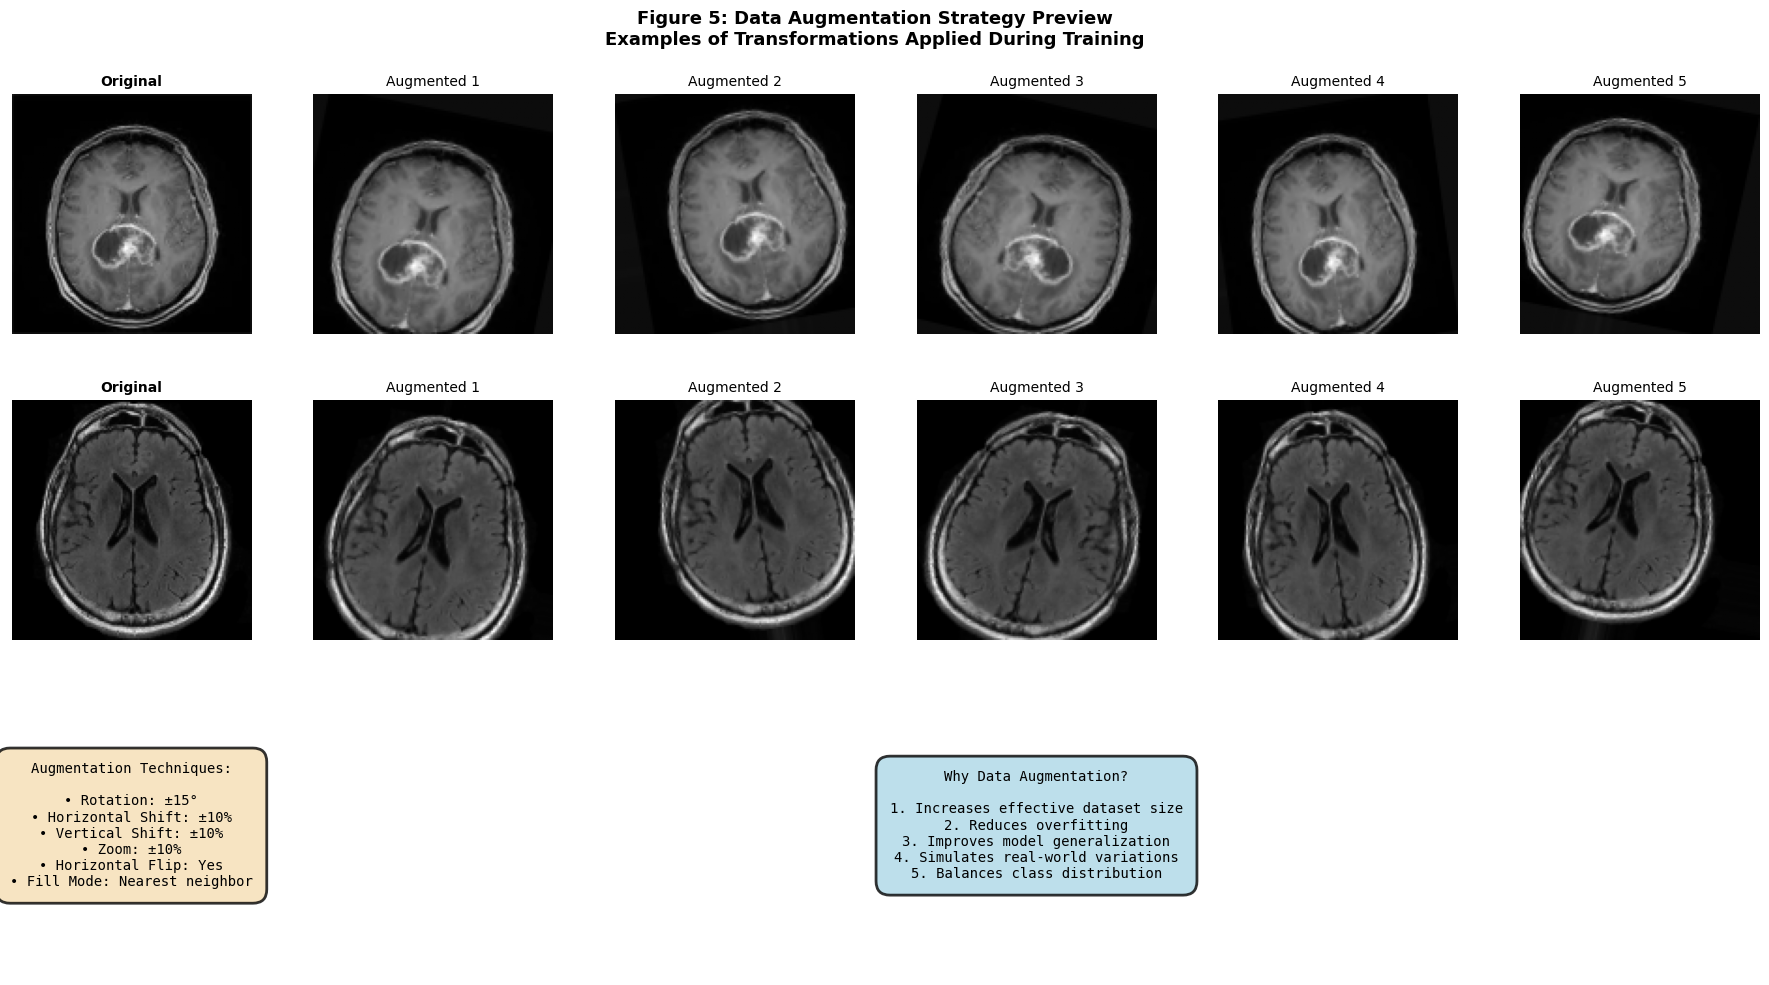


✅ Augmentation preview generated successfully!


In [10]:
# ============================================================================
# 5. DATA AUGMENTATION PREVIEW
# ============================================================================

print("\n" + "="*70)
print("SECTION 5: DATA AUGMENTATION STRATEGY")
print("="*70)

print("\nThese augmentation techniques will be applied during model training")
print("to prevent overfitting and improve model generalization:")
print("  • Rotation: ±15°")
print("  • Width/Height Shift: ±10%")
print("  • Zoom: ±10%")
print("  • Horizontal Flip: Yes")

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Show augmentation examples
fig, axes = plt.subplots(3, 6, figsize=(18, 10))

# Select one image from each class
tumor_idx = np.where(y_train == 1)[0][0]
no_tumor_idx = np.where(y_train == 0)[0][0]

for row, (idx, label, color) in enumerate([
    (tumor_idx, 'WITH Tumor', TUMOR_COLOR), 
    (no_tumor_idx, 'WITHOUT Tumor', NO_TUMOR_COLOR)
]):
    sample_img = X_train[idx].reshape(1, 128, 128, 1)
    
    # Original image
    axes[row, 0].imshow(X_train[idx].squeeze(), cmap='gray')
    axes[row, 0].set_title('Original', fontweight='bold', fontsize=10)
    axes[row, 0].axis('off')
    
    # Add colored border
    for spine in axes[row, 0].spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)
        spine.set_visible(True)
    
    # Add class label on left side
    axes[row, 0].set_ylabel(label, fontsize=11, fontweight='bold', 
                            rotation=0, labelpad=50, va='center')
    
    # 5 augmented versions
    for col in range(1, 6):
        aug_iter = datagen.flow(sample_img, batch_size=1, seed=42+col)
        aug_img = next(aug_iter)[0]
        axes[row, col].imshow(aug_img.squeeze(), cmap='gray')
        axes[row, col].set_title(f'Augmented {col}', fontsize=10)
        axes[row, col].axis('off')
        
        # Add colored border
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
            spine.set_visible(True)

# Add a legend row showing augmentation parameters
axes[2, 0].axis('off')
augmentation_text = (
    "Augmentation Techniques:\n\n"
    "• Rotation: ±15°\n"
    "• Horizontal Shift: ±10%\n"
    "• Vertical Shift: ±10%\n"
    "• Zoom: ±10%\n"
    "• Horizontal Flip: Yes\n"
    "• Fill Mode: Nearest neighbor"
)
axes[2, 0].text(0.5, 0.5, augmentation_text, 
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round,pad=1', 
                         facecolor='wheat', 
                         edgecolor='black',
                         alpha=0.8,
                         linewidth=2),
                family='monospace')

# Add rationale text
for col in range(1, 6):
    axes[2, col].axis('off')

rationale_text = (
    "Why Data Augmentation?\n\n"
    "1. Increases effective dataset size\n"
    "2. Reduces overfitting\n"
    "3. Improves model generalization\n"
    "4. Simulates real-world variations\n"
    "5. Balances class distribution"
)
axes[2, 3].text(0.5, 0.5, rationale_text,
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round,pad=1',
                         facecolor='lightblue',
                         edgecolor='black',
                         alpha=0.8,
                         linewidth=2),
                family='monospace')

plt.suptitle('Figure 5: Data Augmentation Strategy Preview\nExamples of Transformations Applied During Training', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('figure5_data_augmentation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Augmentation preview generated successfully!")

In [11]:
# ============================================================================
# FINAL SUMMARY AND NEXT STEPS
# ============================================================================

print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS - COMPLETE")
print("="*70)

print("\n📊 KEY FINDINGS:")
print("-"*70)
print(f"1. Dataset Size: {len(X_clean)} total UNIQUE images")
print(f"   • Class distribution: {clean_no_count} no tumor, {clean_yes_count} with tumor")
print(f"   • Imbalance ratio: {clean_imbalance_ratio:.2f}:1")

print(f"\n2. Image Properties:")
print(f"   • Standardized size: 128 x 128 pixels")
print(f"   • Color space: Grayscale (1 channel)")
print(f"   • Pixel range: [0.0, 1.0] (normalized)")

print(f"\n3. Data Splits:")
print(f"   • Training set: {len(X_train)} images ({len(X_train)/len(X_clean)*100:.1f}%)")
print(f"   • Validation set: {len(X_val)} images ({len(X_val)/len(X_clean)*100:.1f}%)")
print(f"   • Stratified by class to maintain distribution")
print(f"   • ✅ ZERO overlapping images between train/val")

print(f"\n4. Statistical Insights:")
print(f"   • Mean pixel intensity (tumor): {yes_pixels.mean():.1f}")
print(f"   • Mean pixel intensity (no tumor): {no_pixels.mean():.1f}")
if p_value < 0.05:
    print(f"   • Statistically significant difference detected (p={p_value:.4e})")
else:
    print(f"   • No significant intensity difference (p={p_value:.4f})")

print(f"\n5. Augmentation Strategy:")
print(f"   • Rotation, shifts, zoom, and flips configured")
print(f"   • Will be applied during training to reduce overfitting")

print("\n" + "="*70)
print("NEXT STEPS (WEEK TWO)")
print("="*70)
print("1. ✅ Load preprocessed data (X_train.npy, y_train.npy, etc.)")
print("2. 🔨 Build CNN architecture:")
print("     • Input layer (128x128x1)")
print("     • Convolutional layers with ReLU activation")
print("     • MaxPooling layers for dimensionality reduction")
print("     • Dropout layers for regularization")
print("     • Dense layers with final sigmoid output")
print("3. 🎯 Compile model:")
print("     • Loss: Binary Cross-Entropy")
print("     • Optimizer: Adam")
print("     • Metrics: Accuracy, Precision, Recall, AUC")
print("4. 🚀 Train model:")
print("     • Apply data augmentation to training set")
print("     • Monitor validation metrics")
print("     • Implement early stopping and model checkpointing")
print("5. 📈 Evaluate performance:")
print("     • Plot training/validation curves")
print("     • Generate confusion matrix")
print("     • Calculate ROC-AUC score")
print("     • Analyze misclassifications")
print("6. 🎨 Optional: Compare with transfer learning model")
print("     • MobileNetV2 or ResNet50 pre-trained on ImageNet")

print("\n" + "="*70)
print("💾 FILES GENERATED:")
print("="*70)
print("Data Files:")
print("  • X_train.npy - Training images (CLEAN, no duplicates)")
print("  • X_val.npy - Validation images (CLEAN, no duplicates)")
print("  • y_train.npy - Training labels")
print("  • y_val.npy - Validation labels")
print("\nVisualization Files:")
print("  • figure1_class_distribution.png")
print("  • figure2_image_sizes.png")
print("  • figure3_pixel_intensity.png")
print("  • figure4_sample_images.png")
print("  • figure5_data_augmentation.png")

print("\n" + "="*70)
print("🎉 WEEK ONE COMPLETE - READY FOR MODEL DEVELOPMENT!")
print("="*70)


EXPLORATORY DATA ANALYSIS - COMPLETE

📊 KEY FINDINGS:
----------------------------------------------------------------------
1. Dataset Size: 228 total UNIQUE images
   • Class distribution: 87 no tumor, 141 with tumor
   • Imbalance ratio: 1.62:1

2. Image Properties:
   • Standardized size: 128 x 128 pixels
   • Color space: Grayscale (1 channel)
   • Pixel range: [0.0, 1.0] (normalized)

3. Data Splits:
   • Training set: 182 images (79.8%)
   • Validation set: 46 images (20.2%)
   • Stratified by class to maintain distribution
   • ✅ ZERO overlapping images between train/val

4. Statistical Insights:
   • Mean pixel intensity (tumor): 68.3
   • Mean pixel intensity (no tumor): 69.6
   • Statistically significant difference detected (p=1.2577e-28)

5. Augmentation Strategy:
   • Rotation, shifts, zoom, and flips configured
   • Will be applied during training to reduce overfitting

NEXT STEPS (WEEK TWO)
1. ✅ Load preprocessed data (X_train.npy, y_train.npy, etc.)
2. 🔨 Build CNN arc

In [12]:
# ============================================================================
# SAVE DATASET METADATA
# ============================================================================

print("\n" + "-"*70)
print("SAVING DATASET METADATA")
print("-"*70)

metadata = {
    'dataset_name': 'Brain Tumor MRI Detection',
    'source': 'https://www.kaggle.com/datasets/arwabasal/brain-tumor-mri-detection',
    'author': 'Sheila Adams-Sapper',
    'date_processed': '2025-10-13',
    'total_images': int(len(X_clean)),
    'class_0_count': int(clean_no_count),
    'class_1_count': int(clean_yes_count),
    'class_names': ['no_tumor', 'tumor'],
    'imbalance_ratio': float(clean_imbalance_ratio),
    'duplicates_removed': int(len(X_raw_hashes) - len(X_clean)) if 'X_raw_hashes' in locals() else 0,
    'image_properties': {
        'original_sizes_varied': True,
        'standardized_size': '128x128',
        'channels': 1,
        'color_space': 'grayscale',
        'pixel_range': '[0.0, 1.0]',
        'normalization_method': 'divide_by_255'
    },
    'data_splits': {
        'train_size': int(len(X_train)),
        'val_size': int(len(X_val)),
        'test_size': 0,
        'split_ratio': '80/20/0',
        'stratified': True,
        'random_state': 42,
        'data_leakage_verified': True
    },
    'pixel_statistics': {
        'tumor_mean_intensity': float(yes_pixels.mean()),
        'no_tumor_mean_intensity': float(no_pixels.mean()),
        'statistical_test': 't_test',
        'p_value': float(p_value),
        'significant_difference': bool(p_value < 0.05)
    },
    'augmentation_strategy': {
        'rotation_range': 15,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
        'zoom_range': 0.1,
        'horizontal_flip': True,
        'fill_mode': 'nearest',
        'applied_to': 'training_only'
    },
    'files_generated': [
        'X_train.npy',
        'X_val.npy', 
        'y_train.npy',
        'y_val.npy',
        'filenames_train.npy',
        'filenames_val.npy',
        'figure1_class_distribution.png',
        'figure2_image_sizes.png',
        'figure3_pixel_intensity.png',
        'figure4_sample_images.png',
        'figure5_data_augmentation.png'
    ],
    'memory_usage_mb': float(X_clean.nbytes / (1024**2)),
    'preprocessing_steps': [
        '1. Load images as grayscale',
        '2. Create content hash for duplicate detection',
        '3. Resize to 128x128 pixels',
        '4. Normalize pixel values to [0,1]',
        '5. Remove duplicates BEFORE splitting',
        '6. Split into train/validation sets',
        '7. Verify no data leakage'
    ]
}

import json
with open('dataset_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✅ Metadata saved to: dataset_metadata.json")
print(f"   • Contains {len(metadata)} metadata fields")
print(f"   • File size: {len(json.dumps(metadata, indent=4))} characters")


----------------------------------------------------------------------
SAVING DATASET METADATA
----------------------------------------------------------------------
✅ Metadata saved to: dataset_metadata.json
   • Contains 17 metadata fields
   • File size: 2186 characters
